In [2]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [3]:
path = 'mtcnn-20220418-125039'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [4]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [5]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-18 12:50:39.329344,2.6,3842834432
1,2022-04-18 12:50:54.655344,44.2,3169533952
2,2022-04-18 12:51:05.677342,55.3,3167694848
3,2022-04-18 12:51:16.840343,55.1,3133292544
4,2022-04-18 12:51:28.030842,55.4,3148849152
...,...,...,...
78,2022-04-18 13:05:22.394844,59.2,2493001728
79,2022-04-18 13:05:33.715842,58.6,2499866624
80,2022-04-18 13:05:45.002344,59.1,2515763200
81,2022-04-18 13:05:56.267343,55.4,2545463296


In [6]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

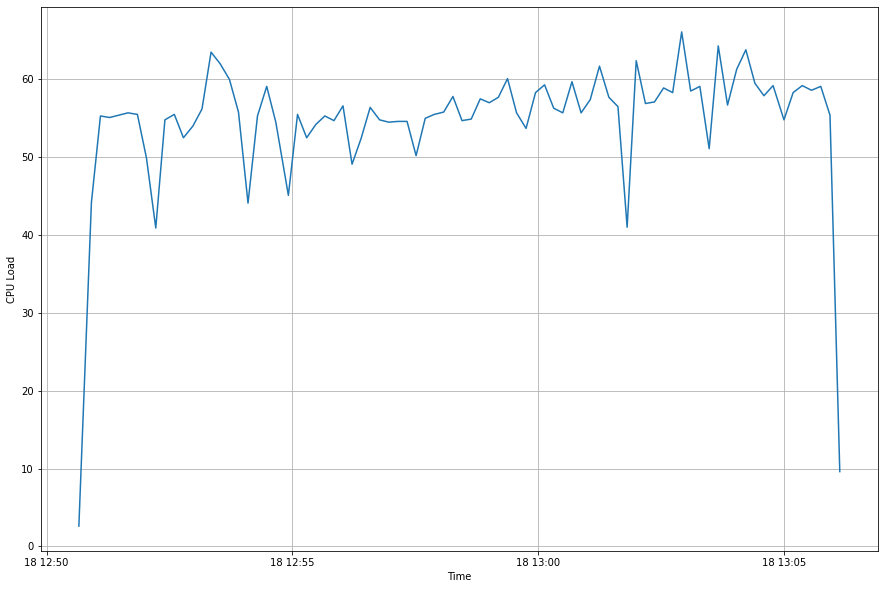

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

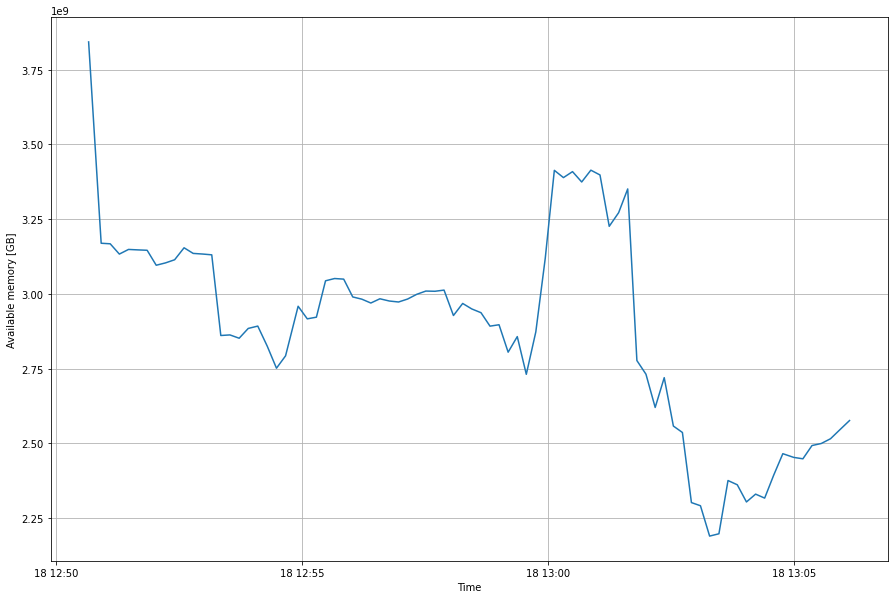

In [8]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

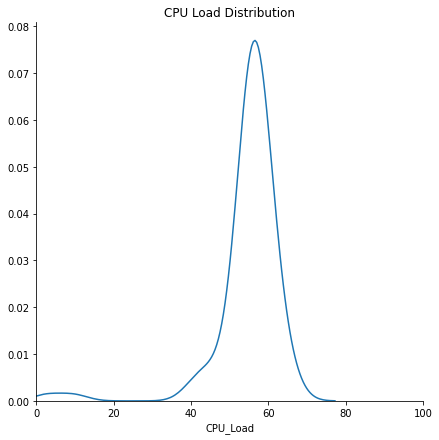

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

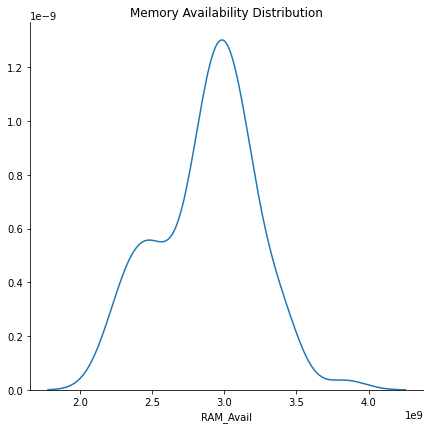

In [10]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [11]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-18 12:50:40.051344,280717300,1.000000,1.000000,1.000000,"[0.8915242805755396, 0.8778703002775675, 0.771...",8,0,0,8,"[(176.0, 141.0, 255.0, 245.0), (785.0, 190.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-18 12:50:40.315845,258171500,0.000000,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-18 12:50:40.508342,185677000,1.000000,1.000000,1.000000,"[0.8058647841433614, 0.8445652173913043]",2,0,0,2,"[(551.0, 117.0, 604.0, 174.0), (459.0, 48.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-18 12:50:40.863343,230343500,1.000000,0.112903,0.202899,"[0.8086548488008342, 0.7382198952879581, 0.830...",7,0,55,62,"[(61.0, 494.0, 99.0, 541.0), (254.0, 496.0, 29...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-18 12:50:41.142342,257272700,1.000000,1.000000,1.000000,"[0.8859470468431772, 0.8551800965466023, 0.807...",8,0,0,8,"[(268.0, 70.0, 317.0, 128.0), (410.0, 89.0, 45...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-18 13:05:56.999843,308717700,1.000000,1.000000,1.000000,[0.7898197662903546],1,0,0,1,"[(457.0, 159.0, 584.0, 316.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-18 13:05:57.396843,387965200,1.000000,1.000000,1.000000,"[0.767156406918356, 0.7021690767519466]",2,0,0,2,"[(715.0, 421.0, 797.0, 531.0), (331.0, 415.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-18 13:05:57.810843,328368000,0.964286,1.000000,0.981818,"[0.8267477203647416, 0.875, 0.8185483870967742...",27,1,0,27,"[(736.0, 501.0, 768.0, 540.0), (521.0, 479.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-18 13:05:57.981843,152698000,1.000000,0.857143,0.923077,"[0.8199643493761141, 0.7321225879682179, 0.959...",6,0,1,7,"[(855.0, 82.0, 901.0, 142.0), (113.0, 109.0, 1...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [12]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.471858e+08,0.844557,0.709128,0.730308,4.967452,0.322071,7.341290,12.308741
std,1.197219e+08,0.306910,0.362114,0.329542,11.027711,0.692007,33.725822,39.822258
min,7.049710e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.680255e+08,0.857143,0.443078,0.571429,1.000000,0.000000,0.000000,1.000000
50%,2.242784e+08,1.000000,1.000000,0.857143,2.000000,0.000000,0.000000,3.000000
75%,2.920072e+08,1.000000,1.000000,1.000000,5.000000,0.000000,3.000000,9.000000
max,1.788993e+09,1.000000,1.000000,1.000000,267.000000,8.000000,621.000000,709.000000


In [13]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,1.000000,True,True,True
1,1.000000,True,True,False
2,1.000000,True,True,True
3,1.000000,True,True,True
4,1.000000,True,True,False
...,...,...,...,...
17059,0.700543,False,False,False
17060,0.700464,True,True,False
17061,0.700239,True,True,True
17062,0.700187,True,True,False


In [14]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [15]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,1.000000,True,True,False,1.000000,0.000050,1.000000,0.000050,0.500000,0.000025
2,1.000000,True,True,True,1.000000,0.000076,1.000000,0.000076,0.666667,0.000050
3,1.000000,True,True,True,1.000000,0.000101,1.000000,0.000101,0.750000,0.000076
4,1.000000,True,True,False,1.000000,0.000126,1.000000,0.000126,0.600000,0.000076
...,...,...,...,...,...,...,...,...,...,...
17059,0.700543,False,False,False,0.939097,0.403470,0.913130,0.392314,0.620633,0.266647
17060,0.700464,True,True,False,0.939101,0.403496,0.913135,0.392339,0.620597,0.266647
17061,0.700239,True,True,True,0.939104,0.403521,0.913140,0.392364,0.620619,0.266672
17062,0.700187,True,True,False,0.939108,0.403546,0.913145,0.392389,0.620583,0.266672


In [44]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

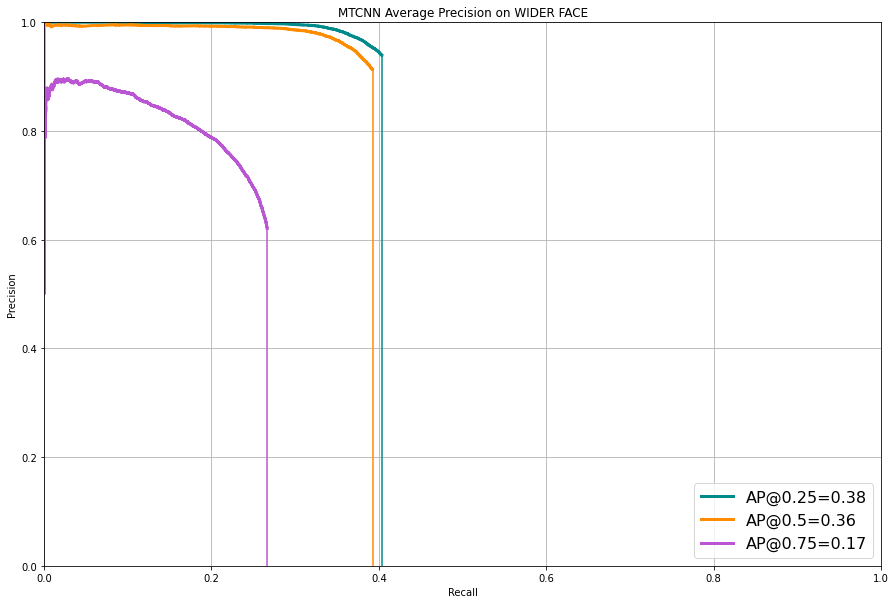

In [45]:
plot_pr(df_ap, 'MTCNN Average Precision on WIDER FACE')